In [1]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
from torchvision.utils import save_image
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from collections import Counter
import glob
import thop
import math

In [2]:
if torch.cuda.is_available():
    # CUDA is available, you can proceed to use it
    device = torch.device('cuda')
    print('CUDA is available. Using GPU.')
else:
    # CUDA is not available, use CPU
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')

CUDA is available. Using GPU.


# Practice getting feature maps on CIFAR10

In [3]:
# ----------------- prepare training data -----------------------
train_data = torchvision.datasets.CIFAR10(
    root='./data.cifar10',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

# ----------------- prepare testing data -----------------------
test_data = torchvision.datasets.CIFAR10(
    root='./data.cifar10/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Make DataLoaders for the training and test data, with a batch size of 64
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [5]:
class_dict = {0: "airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [3]:
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Resize((256,256))])

# ResNet-50 model; hook the feature maps after the max pooling

In [4]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

In [5]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [1]:
num_classes = 10
resnet.fc = nn.Linear(2048, num_classes)

NameError: name 'nn' is not defined

In [7]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
resnet = resnet.to(device)

# tiny-imagenet images

In [10]:
tiny_imagenet_classes = ['n02410509',
                         'n02106662',
                         'n07734744',
                         'n07873807',
                         'n07920052',
                         'n09428293',
                         'n01910747',
                         'n01882714',
                         'n04285008',
                         'n04146614']

In [11]:
current_directory = "."

In [9]:
pattern = 'subclasses-tiny-imagenet/*/images/*.JPEG'

In [10]:
jpeg_files = glob.glob(pattern, recursive=True)

In [11]:
len(jpeg_files)

5000

In [12]:
stage1_files = jpeg_files[:]

In [13]:
stage1_files[0]

'subclasses-tiny-imagenet/n07920052/images/n07920052_389.JPEG'

In [47]:
stage2_files = jpeg_files[::4]

In [48]:
len(stage2_files)

1250

In [49]:
def create_img_data(block_name: str, files: list):

    for x in files:
        file_path = x
        
        # Split the file string
        split_file = x.split('/')
        class_wnid = split_file[1]
        file_name = split_file[3]
        
        with Image.open(file_path) as img:
            
            # Convert grayscale images to RGB
            if img.mode == 'L':
                img = img.convert('RGB')
            
            img_tensor = resnet_transform(img).unsqueeze(0)
            img_tensor = img_tensor.to(device)
            # Pass through the model, and get the feature maps that come out of wherever
            # the hook was placed
            outputs = resnet(img_tensor)
            feature_maps = first_conv_features[0]
            feature_maps = feature_maps.detach().cpu().numpy() # Have to call this to turn tensor into numpy array

            plot_img(feature_maps)
            break

            file_name = file_name.split('.')[0]
            file_name = f"{file_name}_feature_maps"
            save_dir = f"resnet50/{block_name}_input_data/{class_wnid}"
            
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            np.save(f"{save_dir}/{file_name}.npy", feature_maps)

64


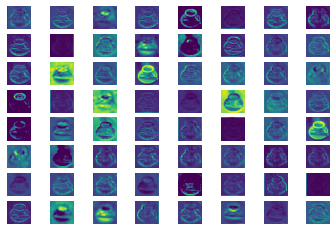

In [53]:
first_conv_features = None

def hook_fn(module, input, output):
    global first_conv_features
    first_conv_features = output

hook_handle = resnet.maxpool.register_forward_hook(hook_fn)
create_img_data("cfg0", stage1_files)
hook_handle.remove()

# hook_handle = resnet.layer1[-1].register_forward_hook(hook_fn)
# create_img_data("cfg1", stage2_files)
# hook_handle.remove()

# Pass images through ResNet, but turn off some of the feature maps

In [14]:
class FineTuningDataset(Dataset):
    def __init__(self, data, transform = resnet_transform):
        '''class_dict = {'n02410509':347,
                      'n02106662':235,
                      'n07734744':947,
                      'n07873807':963,
                      'n07920052':967,
                      'n09428293':978,
                      'n01910747':107,
                      'n01882714':105,
                      'n04285008':817,
                      'n04146614':779}'''
        
        class_dict = {'n02410509':0,
                      'n02106662':1,
                      'n07734744':2,
                      'n07873807':3,
                      'n07920052':4,
                      'n09428293':5,
                      'n01910747':6,
                      'n01882714':7,
                      'n04285008':8,
                      'n04146614':9}
        
        data_and_labels = []
        for i in range(len(data)):
            file_path = data[i]
        
            # Split the file string
            split_file = data[i].split('/')
            class_wnid = split_file[1]
            file_name = split_file[3]
        
            with Image.open(file_path) as img:
            
                # Convert grayscale images to RGB
                if img.mode == 'L':
                    img = img.convert('RGB')
            
                img_tensor = resnet_transform(img)
            
            data_and_labels.append((img_tensor, class_dict[class_wnid]))
        
        self.data = data_and_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx][0]
        target = self.data[idx][1]
        
        return sample, target

In [15]:
data = FineTuningDataset(stage1_files)

In [16]:
# X = [tup[0] for tup in data]
# y = [tup[1] for tup in data]

In [17]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
num_epochs = 10
batch_size = 128

In [32]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [33]:
def fine_tune(model=None, train_loader=None, loss_func=None):
    model = model.to(device)
    
    for epoch in range(1, num_epochs+1):
        train_correct = 0
        train_total = 0
        running_loss = 0.0
        for step, (images, labels) in enumerate(train_loader):
            model.train()   # set the model in training mode
                
            images = images.to(device) # move images and labels to GPU
            labels = labels.to(device)
                
            optimizer.zero_grad() # Zero out gradients from last backprop
                
            outputs = model(images) # Pass images through the model
            _, predicted = torch.max(outputs.data, 1) # Obtain indices of predictions
                
            train_loss = loss_func(outputs, labels) # Get the loss and backpropogate it
            train_loss.backward()
                
            # Get some metrics
            running_loss += train_loss
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum()
            train_accuracy = 100 * (train_correct/train_total)
                
            if step % 5 == 0:
                test_acc, test_loss = test(model=model, test_loader=test_loader, loss_func=loss_func)
                print(f"Epoch: {epoch}, Step: {step}")
                print(f"\tTrain Loss: {running_loss}, Train Accuracy: {train_accuracy}")
                print(f"\tTest Loss: {test_loss}, Test Accuracy: {test_acc}")
                print()
                
            optimizer.step()

In [34]:
def test(model=None, test_loader=None, loss_func=None):
    total = 0
    correct = 0
    
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            test_loss = loss_func(outputs, labels)
            total_loss += test_loss
            
            # Increment total number of observations seen by
            # number of items in this batch
            total += labels.size(0)

            # Increment total number of correct predictions by
            # number of correct predictions in this batch
            correct += (predicted == labels).sum()
            
        accuracy = (100 * (correct/total))
        accuracy = accuracy.item()
        return accuracy, total_loss

In [35]:
fine_tune(model=resnet, train_loader=train_loader, loss_func=criterion)

Epoch: 1, Step: 0
	Train Loss: 0.322469562292099, Train Accuracy: 93.75
	Test Loss: 2.846712350845337, Test Accuracy: 91.10000610351562

Epoch: 1, Step: 5
	Train Loss: 1.9661844968795776, Train Accuracy: 93.09896087646484
	Test Loss: 2.7239086627960205, Test Accuracy: 91.20000457763672

Epoch: 1, Step: 10
	Train Loss: 3.6976335048675537, Train Accuracy: 92.8977279663086
	Test Loss: 2.663175582885742, Test Accuracy: 90.9000015258789

Epoch: 1, Step: 15
	Train Loss: 5.171075344085693, Train Accuracy: 93.212890625
	Test Loss: 2.5718915462493896, Test Accuracy: 90.80000305175781

Epoch: 1, Step: 20
	Train Loss: 6.678676128387451, Train Accuracy: 93.26636505126953
	Test Loss: 2.571143627166748, Test Accuracy: 91.20000457763672

Epoch: 1, Step: 25
	Train Loss: 8.283035278320312, Train Accuracy: 93.05889892578125
	Test Loss: 2.4908201694488525, Test Accuracy: 91.70000457763672

Epoch: 1, Step: 30
	Train Loss: 9.743650436401367, Train Accuracy: 93.17036437988281
	Test Loss: 2.4592103958129883,

Epoch: 9, Step: 0
	Train Loss: 54.080196380615234, Train Accuracy: 94.53125
	Test Loss: 1.8046401739120483, Test Accuracy: 93.20000457763672

Epoch: 9, Step: 5
	Train Loss: 54.80236053466797, Train Accuracy: 96.74479675292969
	Test Loss: 1.7805192470550537, Test Accuracy: 93.20000457763672

Epoch: 9, Step: 10
	Train Loss: 55.51826858520508, Train Accuracy: 96.44886779785156
	Test Loss: 1.7474205493927002, Test Accuracy: 93.20000457763672

Epoch: 9, Step: 15
	Train Loss: 56.24517822265625, Train Accuracy: 96.630859375
	Test Loss: 1.7442443370819092, Test Accuracy: 93.00000762939453

Epoch: 9, Step: 20
	Train Loss: 56.92768096923828, Train Accuracy: 96.61458587646484
	Test Loss: 1.7709708213806152, Test Accuracy: 93.10000610351562

Epoch: 9, Step: 25
	Train Loss: 57.54679489135742, Train Accuracy: 96.78485870361328
	Test Loss: 1.7398812770843506, Test Accuracy: 93.60000610351562

Epoch: 9, Step: 30
	Train Loss: 58.22697448730469, Train Accuracy: 96.92539978027344
	Test Loss: 1.7157348394

### Test model on test data and get accuracy

In [36]:
accuracy, test_loss = test(model=resnet, test_loader=test_loader, loss_func=criterion)

In [37]:
accuracy

93.50000762939453

### Now establish a hook where if you turn the first _X_ feature maps off (to all 0s), then get its accuracy

In [38]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y = []
for num in x:
    def modify_maxpool_output(module, input, output):
        modified_output = output.clone()
        modified_output[:, :num, :, :] = 0
        return modified_output

    hook = resnet.maxpool.register_forward_hook(modify_maxpool_output)
    accuracy, test_loss = test(model=resnet, test_loader=test_loader, loss_func=criterion)
    hook.remove()
    y.append(accuracy)

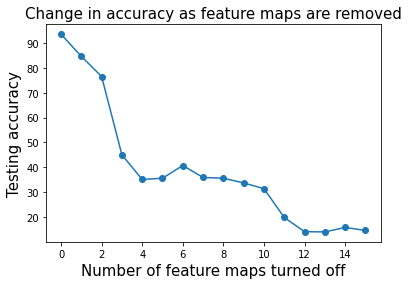

In [39]:
plt.plot(x, y)
plt.scatter(x, y)
plt.xlabel("Number of feature maps turned off", fontsize=15)
plt.ylabel("Testing accuracy", fontsize=15)
plt.title("Change in accuracy as feature maps are removed", fontsize=15)
plt.show()

### Modify output feature maps from the end of stage 1

In [48]:
x = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]
# x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 30]
y = []
for num in x:
    def modify_layer1_output(module, input, output):
        modified_output = output.clone()
        modified_output[:, :num, :, :] = 0
        return modified_output

    hook = resnet.layer1[-1].register_forward_hook(modify_layer1_output)
    accuracy, test_loss = test(model=resnet, test_loader=test_loader, loss_func=criterion)
    hook.remove()
    y.append(accuracy)

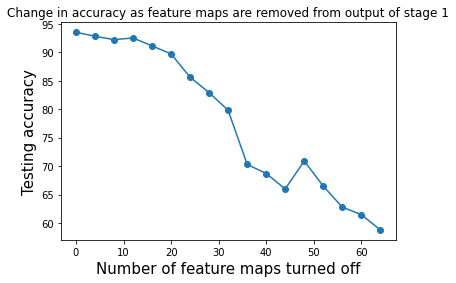

In [49]:
plt.plot(x, y)
plt.scatter(x, y)
plt.xlabel("Number of feature maps turned off", fontsize=15)
plt.ylabel("Testing accuracy", fontsize=15)
plt.title("Change in accuracy as feature maps are removed from output of stage 1", fontsize=12)
plt.show()

In [47]:
print(y)

[93.50000762939453, 92.80000305175781, 93.80000305175781, 93.30000305175781, 92.80000305175781, 92.60000610351562, 91.80000305175781, 92.0, 92.20000457763672, 92.0, 91.4000015258789, 91.5, 92.50000762939453, 92.50000762939453, 92.0, 91.5, 81.30000305175781]


# Visualize said feature maps if you want

In [21]:
def plot_img(feature_maps):
    print(feature_maps.shape[0])
    num_filters = feature_maps.shape[0]
    dim = int(math.sqrt(num_filters))

    # Visualize the feature maps
    fig, axarr = plt.subplots(dim, dim)  # Assuming 32 filters, adjust as needed
    for i in range(num_filters):
        ax = axarr[i // dim, i % dim]

#         image_array = feature_maps[i].detach().cpu().numpy()
        image_array = feature_maps[i]
    
        ax.imshow(image_array, cmap='viridis')
        ax.axis('off')
    plt.show()
#     plt.savefig('CONV_rslt.png')